## Task 5

### Fonte dos dados: [iotanalytics](https://iotanalytics.unsw.edu.au/) e [stratosphereips](https://www.stratosphereips.org/datasets-normal)

1. Criar script que receba um `.pcap` e e gere um `.csv` limpo (excluir as colunas IP O/D,mac O/D, APPlication* e excluir colunas vazias)
2. Escolher um numero de pcaps do IOT analitcs e tratar (~ 400k de fluxos)
3. Gerar fluxos já tratados
4. Rotular os fluxos: criar a coluna "target" (0 -> trafego normal, 1 -> IOT)
5. Unir os arquivos cvs

In [2]:
import pandas as pd
from pandas import DataFrame
from pandas import Index
import nfstream
import os 
import socket
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
pd.set_option("styler.format.thousands", ",")

In [4]:
def concat_csv_and_pcap(mypath: str, fileName:str, label:int) -> DataFrame:

    lista = []

    for arg in os.listdir(path=mypath):

        # camilho completo do arquivo que será aberto
        name = os.path.join(mypath, arg)

        if arg.endswith(".pcap"):
            
            try:
                df = nfstream.NFStreamer(source= os.path.join(mypath, arg),statistical_analysis=True).to_pandas()
                lista.append(df)

            except Exception as e:
                print(f"Error!, ao ler o arquivo {name}")
                exit()
    
    data = pd.concat(lista)
    data['label'] = label # rotulando o trafego
    
    arg = open(fileName,'w')
    arg.write(data.to_csv())
    arg.close()
    return data

In [5]:
try:
    dados_IOT = pd.read_csv("./csv/trafego_IOT.csv")
except:
    dados_IOT = concat_csv_and_pcap("./pcaps/IOT/", "./csv/trafego_IOT.csv", 1)

In [6]:
dados_IOT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415021 entries, 0 to 415020
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    415021 non-null  int64  
 1   id                            415021 non-null  int64  
 2   expiration_id                 415021 non-null  int64  
 3   src_ip                        415021 non-null  object 
 4   src_mac                       415021 non-null  object 
 5   src_oui                       415021 non-null  object 
 6   src_port                      415021 non-null  int64  
 7   dst_ip                        415021 non-null  object 
 8   dst_mac                       415021 non-null  object 
 9   dst_oui                       415021 non-null  object 
 10  dst_port                      415021 non-null  int64  
 11  protocol                      415021 non-null  int64  
 12  ip_version                    415021 non-nul

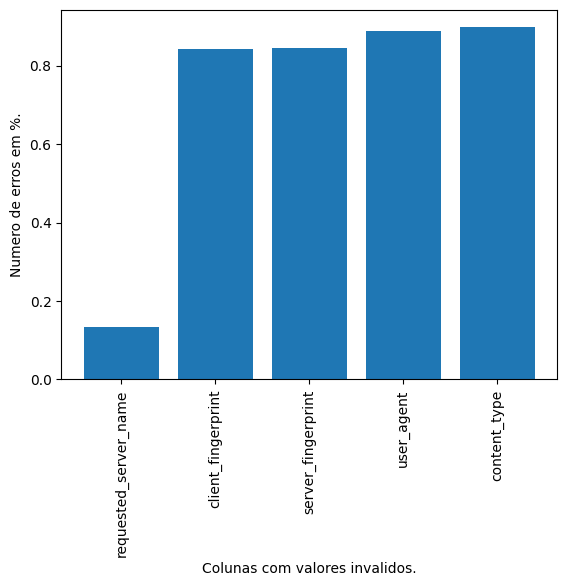

In [7]:

def ratio_isna (data:DataFrame) -> None:

    # obtém o número de pontos de dados ausentes por coluna
    data_cols_erros = dados_IOT.isnull().sum()

    data_cols_erros = data_cols_erros[data_cols_erros > 0]

    size = len(data.index)

    # obtendo uma lista das colunas
    cols_name = data_cols_erros.index.tolist()

    # obtendo os uma lista com os valores de erro de cada coluna
    erros = [float(item / size) for item in data_cols_erros.values.tolist()]

    plt.bar(cols_name, erros)

    plt.xlabel("Colunas com valores invalidos.")
    plt.ylabel("Numero de erros em %.")

    plt.xticks(rotation = 90)
    plt.show()

ratio_isna(dados_IOT)

In [7]:
# removendo 0 ou mais ocorrencias das colunas que possuem application no inicio -> application_name	application_category_name	application_is_guessed	application_confidence
def cleaning_by_labels (data:DataFrame) -> Index:
    
    # seleciona as colunas que começão com application para serem removidas
    cols_to_drop = data.filter(regex=r'^application_*')

    # remove todas as colunas contidas na lista
    df_filtrado = data.drop(columns=['src_ip','src_mac', 'dst_ip', 'dst_mac'] + list(cols_to_drop.columns))

    return df_filtrado, data.columns.difference(df_filtrado.columns)

dados_IOT_cleared, c1 = cleaning_by_labels(dados_IOT)


In [8]:

def cleaning_by_isna (data:DataFrame) -> Index:

    # remove colunas que possuem mais de 50% de valores inválidos
    limite = len(data) / 2 
    DF_cleared = data.dropna(axis=1, thresh=limite)

    # remove todas as linhas que possuem algum valor null or vazio
    DF_cleared = DF_cleared.dropna(axis=0, how='any')

    # para saber as colunas que foram reovidas nesse passo
    return DF_cleared, data.columns.difference(DF_cleared.columns)

dados_IOT_cleared, c2 = cleaning_by_isna(dados_IOT_cleared)

In [9]:
res = open('./csv/trafego_IOT_limpo.csv','w')
res.write(dados_IOT_cleared.to_csv())
res.close()

# Task 6 - Inicio da faze de treinamento
* Relatório das colunas excluidas.
* Desafio do titanic.
* Criar um modelosup com os dados obtidos até o momento.

In [10]:
try:
    dados_Normal = pd.read_csv("./csv/trafego_normal.csv")
except:
    dados_Normal = concat_csv_and_pcap("./pcaps/Fixo/", "./csv/trafego_normal.csv", 0)

In [14]:
dados_normal_clear, n1 = cleaning_by_labels(dados_Normal)

dados_normal_clear, n2 = cleaning_by_isna(dados_normal_clear)

dados_normal_clear.to_csv('./csv/trafego_normal_limpo.csv')

In [16]:
dados_IOT_cleared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359377 entries, 0 to 74529
Data columns (total 75 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            359377 non-null  int64  
 1   expiration_id                 359377 non-null  int64  
 2   src_oui                       359377 non-null  object 
 3   src_port                      359377 non-null  int64  
 4   dst_oui                       359377 non-null  object 
 5   dst_port                      359377 non-null  int64  
 6   protocol                      359377 non-null  int64  
 7   ip_version                    359377 non-null  int64  
 8   vlan_id                       359377 non-null  int64  
 9   tunnel_id                     359377 non-null  int64  
 10  bidirectional_first_seen_ms   359377 non-null  int64  
 11  bidirectional_last_seen_ms    359377 non-null  int64  
 12  bidirectional_duration_ms     359377 non-null

In [25]:
linhas_removidas_IOT = dados_IOT[~dados_IOT.index.isin(dados_IOT_cleared.index)]

linhas_removidas_Normal = dados_Normal[~dados_Normal.index.isin(dados_normal_clear.index)]

linhas_removidas_Normal

,Unnamed: 0,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,...,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,label
0,0,0,0,fe80::69dd:e614:2b2:dfd0,08:00:27:a3:83:43,08:00:27,0,ff02::16,33:33:00:00:00:16,33:33:00,...,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN,0
1,1,1,0,::,08:00:27:a3:83:43,08:00:27,0,ff02::1:ffb2:dfd0,33:33:ff:b2:df:d0,33:33:ff,...,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN,0
2,2,2,0,fe80::69dd:e614:2b2:dfd0,08:00:27:a3:83:43,08:00:27,0,ff02::2,33:33:00:00:00:02,33:33:00,...,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN,0
4,4,4,0,10.0.2.2,52:54:00:12:35:02,52:54:00,67,10.0.2.15,08:00:27:a3:83:43,08:00:27,...,DHCP,Network,0,6,NaN,NaN,NaN,NaN,NaN,0
5,5,5,0,fe80::69dd:e614:2b2:dfd0,08:00:27:a3:83:43,08:00:27,546,ff02::1:2,33:33:00:01:00:02,33:33:00,...,DHCPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404422,18551,18551,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,49373,23.51.123.27,52:54:00:12:35:02,52:54:00,...,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN,0
404423,18552,18552,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,49374,23.51.123.27,52:54:00:12:35:02,52:54:00,...,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN,0
404445,18574,18574,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,49381,172.217.23.142,52:54:00:12:35:02,52:54:00,...,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN,0
404450,18579,18579,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,49382,31.13.93.7,52:54:00:12:35:02,52:54:00,...,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN,0


In [28]:
linhas_removidas_IOT.to_csv('./Relatorios/linhas_excluidas_IOT.csv')

In [30]:
linhas_removidas_Normal.to_csv('./Relatorios/linhas_excluidas_Normal.csv')

In [33]:
import ydata_profiling 


profile_Normal = ydata_profiling.ProfileReport(dados_Normal, minimal=True)

profile_IOT = ydata_profiling.ProfileReport(dados_IOT, minimal=True)

profile_Normal_cleared = ydata_profiling.ProfileReport(dados_normal_clear, minimal=True)

profile_IOT_cleared = ydata_profiling.ProfileReport(dados_IOT_cleared, minimal=True)

profile_Normal_erros = ydata_profiling.ProfileReport(linhas_removidas_Normal, minimal=True)

profile_IOT_erros = ydata_profiling.ProfileReport(linhas_removidas_IOT, minimal=True)

# Exibindo o relatório do perfil
profile_Normal.to_file("./Relatorios/trafego_normal_bruto.html")

profile_IOT.to_file("./Relatorios/trafego_IOT_bruto.html")

profile_Normal_cleared.to_file("./Relatorios/trafego_normal_limpo.html")

profile_IOT_cleared.to_file("./Relatorios/trafego_IOT_limpo.html")

profile_Normal_erros.to_file("./Relatorios/trafego_normal_erros.html")

profile_IOT_erros.to_file("./Relatorios/trafego_IOT_erros.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 67.13it/s]
/home/maycon/IC-RedesDomesticas/.env/lib/python3.10/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 50.31it/s]
/home/maycon/IC-RedesDomesticas/.env/lib/python3.10/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


In [37]:
erros_Normal = dados_Normal.isnull().sum()

erros_Normal = erros_Normal[erros_Normal > 0 ]

[item / len(dados_Normal.index) for item in erros_Normal.values]

[0.07324795894910906,
 0.8279510889312383,
 0.8285813862090956,
 0.8922414112726814,
 0.9017057574566639]

In [ ]:
print(f"Normal ({len(dados_Normal.index)} - {len(linhas_removidas_Normal.index)})")

Normal (404571 - 29634)


In [ ]:
print(f"IOT ({len(dados_IOT.index)} - {len(linhas_removidas_IOT.index)})")

IOT (415021 - 55644)


In [ ]:
print(f"Normal {n2} || IOT {c2}")

Normal Index(['client_fingerprint', 'content_type', 'server_fingerprint',
       'user_agent'],
      dtype='object') || IOT Index(['client_fingerprint', 'content_type', 'server_fingerprint',
       'user_agent'],
      dtype='object')


In [40]:
aux = dados_normal_clear.isnull().sum()

# aux = aux[aux > 0]

aux

Unnamed: 0               0
id                       0
expiration_id            0
src_oui                  0
src_port                 0
                        ..
dst2src_psh_packets      0
dst2src_rst_packets      0
dst2src_fin_packets      0
requested_server_name    0
label                    0
Length: 76, dtype: int64

In [41]:
aux = dados_IOT_cleared.isnull().sum()

aux = aux[aux > 0]

aux

Series([], dtype: int64)